In [4]:
import numpy as np
from matplotlib import colormaps
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [5]:
# ground truth data
ground_truths = np.load('mt_trajectories.npy')
# ground_truths

## Background

### Motion model

In [6]:
# # utility functions
# this is the version for [x, dx, y, dy]
# def create_state_matrix(dt:float= 1.0, dim:int = 2):
#     mat = []
#     for i in range(dim):
#         row = []
#         for j in range(dim):
#             if i == j:
#                 row.append(np.array([[1, dt], [0, 1]]))
#             else:
#                 row.append(np.zeros((2, 2)))
#         mat.append(row)
#     return np.block(mat)

def create_state_matrix(dt:float = 1.0, dim:int = 2)->np.ndarray:
    """Creates a state transition matrix for an n-dimensional constant velocity model.

    The matrix is composed of four (dim x dim) blocks:

        [ I   I*dt ]
        [ 0     I  ]

    where:
        - I is the identity matrix
        - 0 is the zero matrix
        - dt is the timestep length

    Args:
        dt (float, optional): Length of a single timestep. Defaults to 1.0.
        dim (int, optional): Number of spatial dimensions. Set to 2 for 2D (x, y) motion, 3 for 3D (x, y, z) motion, etc. Defaults to 2.

    Returns:
        np.ndarray: The state transition matrix.
    """
    return np.vstack((
        np.hstack((np.identity(dim), np.identity(dim) * dt)),
        np.hstack((np.zeros((dim, dim)), np.identity(dim)))
    ))


def create_measurement_matrix(dim:int = 2)->np.ndarray:
    """Creates a measurement matrix for an n-dimensional constant velocity model.

    The matrix H maps the full state to position measurements only:

        [ I  0 ]

    where:
        - I is the identity matrix (measures position)
        - 0 is the zero matrix (ignores velocity)

    Args:
        dim (int, optional): Number of spatial dimensions. Set to 2 for 2D (x, y) motion, 3 for 3D (x, y, z) motion, etc. Defaults to 2.

    Returns:
        np.ndarray: The measurement matrix.
    """
    return np.hstack((np.identity(dim), np.zeros((dim, dim))))

The motion model describes how objects of a system move. Define the motion model as $$x_{k+1} = F \times x_{k} + w_{k}$$ where
\begin{gather*}
    \text{$x_{k+1}$: next state} \\
    \text{$F$: state transition matrix} \\
    \text{$x_{k}$: current state} \\
    \text{$w_{k}$: process noise.} \\
\end{gather*}

Assume motion is constant velocity in 2 dimensions, where state is represented by $[x, y, v_{x}, v_{y}]$ (i.e., x-pos, y-pos, x-vel, y-vel). Then, $F$ is defined by
$$ F = \begin{bmatrix}
    1 & 0 & dt & 0 \\
    0 & 1 & 0 & dt \\
    0 & 0 & 1 & 0 \\
    0 & 0 & 0 & 1 \\
\end{bmatrix}.$$

In [7]:
# dimensions
dim = 2
# timestep (1s)
dt = 1.0
# state transition matrix
F = create_state_matrix(dt, dim)
F

array([[1., 0., 1., 0.],
       [0., 1., 0., 1.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

Assume $w_{k}$ has 0 mean and 0.25 variance. Sampled from a multivariate Gaussian, its covariance $Q$ is defined by
$$ Q = \begin{bmatrix}
    0.25 & 0 & 0 & 0 \\
    0 & 0.25 & 0 & 0 \\
    0 & 0 & 0.25 & 0 \\
    0 & 0 & 0 & 0.25 \\
\end{bmatrix}.$$

In [8]:
# process noise covariance
Q = np.identity(F.shape[0]) * 0.25
Q

array([[0.25, 0.  , 0.  , 0.  ],
       [0.  , 0.25, 0.  , 0.  ],
       [0.  , 0.  , 0.25, 0.  ],
       [0.  , 0.  , 0.  , 0.25]])

In [9]:
def simulate_motion_basic(num_steps:int=10, init_truths:int=3)->dict[int, list[np.ndarray]]:
    """Simulates simple motion of multiple objects in an n-dimensional space.

    Args:
        num_steps (int, optional): Number of timesteps to simulate. Defaults to 10.
        init_truths (int, optional): Number of initial objects. Defaults to 3.

    Returns:  
        dict[int, list[np.ndarray]]: Dictionary containing the states of each object at each timestep. Each key is the object index (0, 1, 2, ...). Each value is a list of state vectors with shape (4,) representing (x, y, dx, dy). 
    """
    all_states = {}
    # initial truths
    for i in range(init_truths):
        state = np.array([
            # initial position (x, y) ~ U(-30, 30) x U(-30, 30)
            *np.random.uniform(-30, 30, 2),
            # initial velocity (dx, dy) ~ U(-2, 2) x U(-2, 2)
            *np.random.uniform(-2, 2, 2),
        ])

        all_states[i] = [state.copy()]

    for step in range(1, num_steps + 1):
        
        # propagate state for each object
        for i in all_states.keys():
            # get previous state
            state = all_states[i][-1]

            # propagate state with noise
            new_state = F @ state + np.random.multivariate_normal(np.zeros(Q[0].size), Q)
            
            all_states[i].append(new_state.copy())

    return all_states


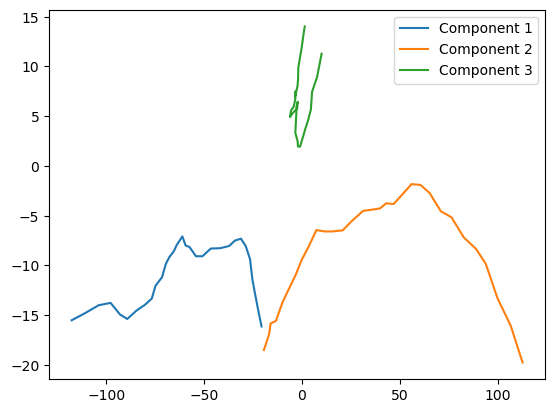

In [10]:
# generate ground truths (i.e., true motion)
# assume 3 components
%matplotlib inline
num_components = 3
ground_truths = simulate_motion_basic(num_steps=30, init_truths=num_components)
for i, state in ground_truths.items():
    pos = np.array([s[:2] for s in state])
    plt.plot(*pos[:,:2].T, label=f'Component {i + 1}')
    plt.legend()
plt.show()

Now, assume objects have a specific birth and death probability. Birth refers to the spontaneous introduction of an object into a scene, whereas death refers to the spontaneous removal of an object from a scene.

In [11]:
def simulate_motion(F:np.ndarray, Q:np.ndarray, num_steps:int = 10, init_truths:int = 3, birth_prob:float = 0.2, death_prob:float = 0.05)->dict[int, list[np.ndarray]]:
    """Simulates the motion of multiple objects in an n-dimensional space with birth and death probabilities. A generalized form of the previous method to include birth and death probabilities.   

    Args:
        F (np.ndarray): State transition matrix. Must match the dimensions of the state vector.
        Q (np.ndarray): Process noise covariance matrix. Must match the dimensions of the state vector.
        num_steps (int, optional): Number of timesteps to simulate. Defaults to 10.
        init_truths (int, optional): Number of initial objects. Defaults to 3.
        birth_prob (float, optional): Probability that a new object is born. Defaults to 0.2.
        death_prob (float, optional): Probability that an existing object dies. Defaults to 0.05.

    Returns:  
        dict[int, list[np.ndarray]]: Dictionary containing the states of each object at each timestep. Each key is the object index (0, 1, 2, ...). Each value is a list of state vectors with shape (4,) representing (x, y, dx, dy). 
    """
    
    all_states = {}
    # initial truths
    for i in range(init_truths):
        state = np.array([
            # initial position (x, y) ~ U(-30, 30) x U(-30, 30)
            *np.random.uniform(-30, 30, 2),
            # initial velocity (dx, dy) ~ U(-2, 2) x U(-2, 2)
            *np.random.uniform(-2, 2, 2),
        ])

        # initial state at t=0
        all_states[i] = [state.copy()]

    # next id for new objects that are born
    next_id = init_truths

    for step in range(1, num_steps + 1):
        
        for i in all_states.keys():
            # get i's previous (t-1) state
            state = all_states[i][-1]

            # if dead, stay dead
            if state is None:
                # None is used to indicate that the object is dead at this timestep
                all_states[i].append(None)
                continue

            # death
            if np.random.rand() <= death_prob:
                # None is used to indicate that the object is dead at this timestep
                all_states[i].append(None)
                continue

            # propagate state (with noise) for each object
            new_state = F @ state + np.random.multivariate_normal(np.zeros(Q[0].size), Q)

            all_states[i].append(new_state.copy())

        # birth
        if np.random.rand() <= birth_prob:
            state = np.array([
                *np.random.uniform(-30, 30, 2),
                *np.random.uniform(-2, 2, 2),
            ])
            # since we are adding a new object, we need to set its state to None for all previous timesteps
            all_states[next_id] = [None] * step + [state.copy()]

            # increment id for the next new object
            next_id += 1

    return all_states

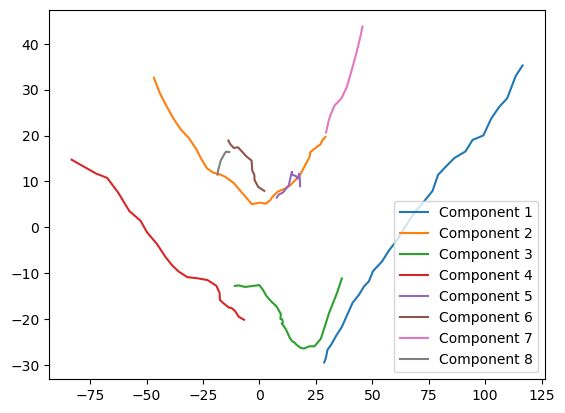

In [12]:
birth_death_truths = simulate_motion(F, Q, num_steps=30, birth_prob=0.05, death_prob=0.005)
for i, state in birth_death_truths.items():
    pos = np.array([s[:2] if s is not None else [np.nan, np.nan] for s in state])
    plt.plot(*pos[:,:2].T, label=f'Component {i + 1}')
plt.legend()

### Measurement model

The measurement model describes what the sensor sees. Define the measurement model as $$ z_{k} = Hx_{k} + v_{k}$$ where
\begin{gather*}
    \text{$z_{k}$: observed measurement} \\
    \text{$H$: measurement matrix} \\
    \text{$v_{k}$: measurement noise.} \\
\end{gather*}

Assume a sensor only measures position. Then, $H$ is defined by
$$ H = \begin{bmatrix}
    1 & 0 & 0 & 0 \\
    0 & 1 & 0 & 0 \\
\end{bmatrix}.$$


In [13]:
# measurement matrix
H = create_measurement_matrix(dim)
H

array([[1., 0., 0., 0.],
       [0., 1., 0., 0.]])

Assume $v_{k}$ has 0 mean and 0.75 variance. Its covariance R is defined by
$$ R = \begin{bmatrix}
    0.75 & 0 \\
    0 & 0.75 \\
\end{bmatrix}.$$

In [14]:
# measurement noise covariance
R = np.identity(H.shape[0]) * 0.75
R

array([[0.75, 0.  ],
       [0.  , 0.75]])

Assume the sensors have a certain detection rate. Sensors frequently detect objects that are not targets of interest. These objects are referred to as clutter, which have to be filtered out from predictions.

In [15]:
def simulate_measurement(ground_truths:dict[int, list[np.ndarray]], H:np.ndarray, R:np.ndarray, num_steps:int=10, det_prob:float=0.9, clutter_rate:float=3.0)->dict[int, list[tuple[int, np.ndarray]]]:
    """Simulates the measurement process for multiple objects in an n-dimensional space.

    Args:
        ground_truths (dict[int, list[np.ndarray]]): 
            Dictionary containing the states of each object at each timestep. Each key is the object index (0, 1, 2, ...). Each value is a list of state vectors with shape (4,) representing (x, y, dx, dy).
            
        H (np.ndarray): 
            Measurement matrix. Must match the dimensions of the state vector.

        R (np.ndarray): 
            Measurement noise covariance matrix. Must match the dimensions of the measurement vector. 

        num_steps (int, optional): 
            Number of timesteps to simulate. Defaults to 10.

        det_prob (float, optional): 
            Probability of correctly detecting an object at each timestep. Defaults to 0.9.

        clutter_rate (float, optional): 
            Rate at which clutter (false measurements) appears in the measurement process, modeled by a Poisson distribution. Defaults to 3.0.

    Returns:
        dict[int, list[tuple[int, np.ndarray]]]: 
            Dictionary containing the measurements at each timestep, where:
                - Each key is the timestep index (0, 1, 2, ...). 
                - Each value is a list of tuples, where each tuple contains
                    - the object index (or None for clutter) 
                    - the corresponding measurement vector.
    """
    
    # all measurements
    all_measurements = {}

    for step in range(num_steps):
        measurements = []

        # real measurement
        for i, states in ground_truths.items():
            # if step exceeds the number of true states, continue
            if step >= len(states):
                continue

            # get the state at the current timestep
            state = states[step]

            # if an item is dead at the current timestep, continue
            if state is None:
                continue
            
            # detect an object with detection probability
            # if the object is detected, add the measurement
            if np.random.rand() <= det_prob:
                measurement = H @ state + np.random.multivariate_normal(np.zeros(R[0].size), R)
                measurements.append((i, measurement.copy()))

        # clutter
        for _ in range(np.random.poisson(clutter_rate)):
            # clutter (x, y) ~ U(-100, 100) x U(-100, 100)
            clutter = np.array([
                np.random.uniform(-100, 100), 
                np.random.uniform(-100, 100)
            ])
            measurements.append((None, clutter.copy()))
        
        # the measurements for this timestep consist of the real measurements (obj_id, pos) and clutter (None, pos)
        all_measurements[step] = measurements

    return all_measurements


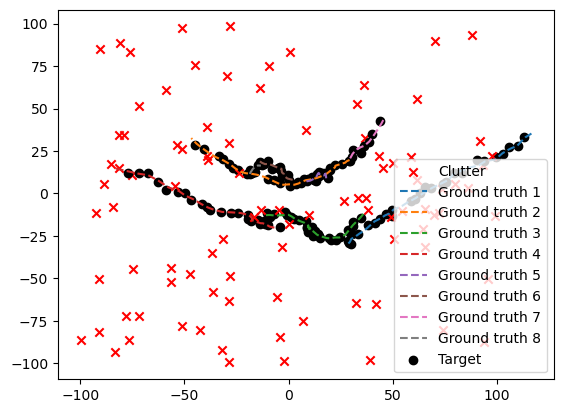

In [16]:
# generate measurements
all_measurements = simulate_measurement(birth_death_truths, H=H, R=R, num_steps=30)

component_ids = sorted({i for measurements in all_measurements.values() for i, _ in measurements if i is not None})

# matplotlib.colormaps
cmap = colormaps['viridis']
colors = [cmap(i / max(len(component_ids) - 1, 1)) for i in range(len(component_ids))]
color_map = {comp: colors[idx] for idx, comp in enumerate(sorted(component_ids))}
# color_map = {comp: colors(idx) for idx, comp in enumerate(sorted(component_ids))}


for measurements in all_measurements.values():
    for i, measurement in measurements:
        if i is None:
            plt.scatter(measurement[0], measurement[1], c='red', marker='x', label='Clutter')
        else:
            # color = color_map[i]
            # plt.scatter(measurement[0], measurement[1], color=color, marker='o', label=f'Component {i + 1}')
            plt.scatter(measurement[0], measurement[1], color='black', marker='o', label=f'Target')
    
for i, state in birth_death_truths.items():
    pos = np.array([s[:2] if s is not None else [np.nan, np.nan] for s in state])
    # print(pos)
    plt.plot(*pos[:,:2].T, label=f'Ground truth {i + 1}', linestyle='dashed')

# ignore duplicates
handles, labels = plt.gca().get_legend_handles_labels()
unique = dict(zip(labels, handles))
order = np.argsort(list(unique.keys()))
plt.legend([list(unique.values())[i] for i in order], [list(unique.keys())[i] for i in order])

## PHD Filter

The PHD filter propagates the first-order stastical moment (mean) of the posterior multiple-target state. 

Suppose, for a multi-target scenario, that the target states at time $k - 1$ are $x_{k-1,1},...,x_{k-1,M(k-1)} \in \mathcal{X}$. For a random finite set (RFS) $X$ on $\mathcal{X}$ with probality distribution $P$, its mean is a nonnegative function $v$ on $\mathcal{X}$ (the intensity) such that
$$
\int |X \cap S| P(dX) = \int_S v(x)dx.
$$

In other words, the integral of $v$ over $S$ is the expected number of elements of $X$ in $S$.

## GM-PHD Filter

The GM-PHD filter approximates the PHD function using Gaussian mixtures. Each target is assumed to follow a linear Gaussian model. The predicted PHD (intensity) at time $k$ is then defined as $$v_{k|k-1}(x) = \sum_{i=1}^{J_{k|k-1}}{w^{i}_{k|k-1}\mathcal{N}(x, m^{i}_{k|k-1},P^{i}_{k|k-1})},$$ where 
\begin{gather*}
    \text{$J_{k|k-1}$: number of components} \\
    \text{$w^{i}_{k|k-1}$: weight of component $i$} \\
    \text{$m^{i}_{k|k-1}$: mean (state vector) of component $i$} \\
    \text{$P^{i}_{k|k-1}$: covariance of component $i$.}\\
\end{gather*}

The birth and spawn RFSs of each component are Gaussian mixtures.

In [17]:
# assume 3 components
num_components = 3

# assume each component has the same weight
component_weight = 1 / 3

# the variance of pos and vel
pos_var = 50
vel_var = 2

# each component assumed to start at a random (x, y) ~ U([-100, 100] x [-100, 100])
start_bounds = (-50, 50)

w = [component_weight] * num_components
m = []
for _ in range(num_components):
    m.append(np.array([
            *np.random.uniform(*start_bounds, 2),
            # initial velocity (dx, dy) ~ U(-2, 2) x U(-2, 2)
            *np.random.uniform(-2, 2, 2),
    ]))
m = np.array(m)
P = np.array([np.diag([pos_var, pos_var, vel_var, vel_var]) for _ in range(num_components)])

In [18]:
print("Initial weights:")
print(w)
print("Initial means:")
print(m)
print("Initial covariances:")
print(P)

Initial weights:
[0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
Initial means:
[[ 2.16397232e+01  3.96001970e+01 -1.09681591e+00 -1.66656635e+00]
 [-2.04797828e+01 -2.50082377e+01  1.00158513e+00  2.98476349e-02]
 [-1.25757807e+00 -4.49644886e+01  7.67552227e-01  1.87042858e+00]]
Initial covariances:
[[[50  0  0  0]
  [ 0 50  0  0]
  [ 0  0  2  0]
  [ 0  0  0  2]]

 [[50  0  0  0]
  [ 0 50  0  0]
  [ 0  0  2  0]
  [ 0  0  0  2]]

 [[50  0  0  0]
  [ 0 50  0  0]
  [ 0  0  2  0]
  [ 0  0  0  2]]]


In [19]:
from gmphd import mtt_phd

# initialize the filter
filter = mtt_phd(
    weights=w,
    position=m,
    p_cov=P,
    num_components=num_components,
    measurement=all_measurements,
    state_transition_matrix=F,
    process_noise_matrix=Q,
    measurement_matrix=H,
    measurement_noise=R,
    num_steps=len(all_measurements),
    detection_probability=0.9,
    clutter_intensity=3.0,
    merging_threshold = 3.0,
    truncation_threshold = 0.001, # make sure squared
    threshold_weight= 0.1
)

# set current measurements to the first timestep (for demonstration)
filter.current_measurements = filter.simulated_measurements[0][1]

The algorithm for GM-PHD recursion consists of 4 steps:

1. Predict birth/spawn targets
2. Predict existing targets
3. Construct PHD update components
4. Update

### Step 1: Predict birth targets

For any single timestep $k$ and given $w_{k-1}$, $m_{k-1}$, and $P_{k-1}$ for all $J_{k-1}$ components, the filter begins by predicting the positions of any birthed and spawned targets. Predicted birth positions are found by simply copying the birth Gaussian mixtures at time $k$, given by 
$$
    \gamma(x) = \sum_{i=1}^{J_{\gamma,k}}{w_{\gamma,k}^{i}\mathcal{N}(x; m^{i}_{\gamma,k},P^{i}_{\gamma,k})}.
$$ 

Essentially, this just initializes new Gaussian mixture components at time $k$.

For now, assume no spawning.

In [20]:
# predict any birthed components
filter.predict_birth()

In [21]:
filter.predicted_weights

[0.3333333333333333, 0.3333333333333333, 0.3333333333333333, 0.1]

In [22]:
filter.predicted_positions

[array([21.63972319, 39.60019699, -1.09681591, -1.66656635]),
 array([-20.47978276, -25.00823767,   1.00158513,   0.02984763]),
 array([ -1.25757807, -44.96448864,   0.76755223,   1.87042858]),
 array([ 5.36409444, 26.06422874,  0.        ,  0.        ])]

In [23]:
filter.predicted_covariance

[array([[50,  0,  0,  0],
        [ 0, 50,  0,  0],
        [ 0,  0,  2,  0],
        [ 0,  0,  0,  2]]),
 array([[50,  0,  0,  0],
        [ 0, 50,  0,  0],
        [ 0,  0,  2,  0],
        [ 0,  0,  0,  2]]),
 array([[50,  0,  0,  0],
        [ 0, 50,  0,  0],
        [ 0,  0,  2,  0],
        [ 0,  0,  0,  2]]),
 array([[25,  0,  0,  0],
        [ 0, 25,  0,  0],
        [ 0,  0,  4,  0],
        [ 0,  0,  0,  4]])]

In [24]:
filter.predicted_positions[0][:2]

array([21.63972319, 39.60019699])

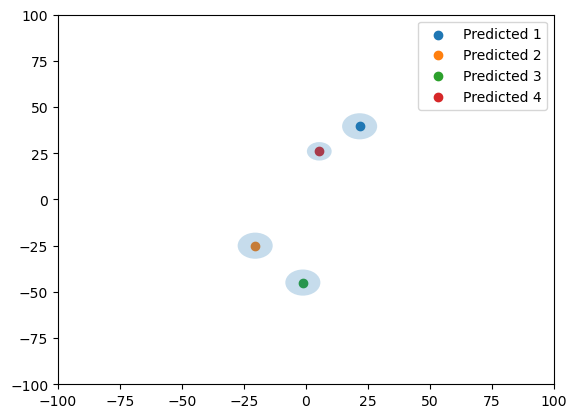

In [25]:
fig, ax = plt.subplots()
for i in range(len(filter.predicted_positions)):
    pos = filter.predicted_positions[i][:2]
    cov = filter.predicted_covariance[i][:2, :2]
    eigvals, eigvecs = np.linalg.eig(cov)
    a = eigvals.argsort()[::-1]
    eigvals = eigvals[a]
    unc = patches.Ellipse(pos, 2 * np.sqrt(eigvals[0]), 2 * np.sqrt(eigvals[1]), angle=0, alpha=0.25)
    ax.scatter(pos[0], pos[1], marker='o', label=f'Predicted {i + 1}')
    ax.add_patch(unc)
    ax.set_xlim(-100, 100)
    ax.set_ylim(-100, 100)
plt.legend()

### Step 2: Predict existing targets

Predicted existing positions are calculated by propagating each $J_{k-1}^{\text{th}}$ component through the motion model by one timestep. The filter computes
$$
    w_{k}^{(i)} = p_{S,k}w_{k-1}^{(j)} \\
    m_{k}^{(i)} = F_{k-1}m_{k-1}^{(j)} \\
    P_{k}^{(i)}  = Q_{k-1} + F_{k-1}P_{k-1}^{(j)}F_{k-1}^{T}
$$ 
for each $i^{\text{th}}$ existing target and each $j \in J_{k-1}$. The weight of each component at time $k$ is multiplied by the survival probability $p_{S,k} < 1$; as a target is assumed to survive longer, it is increasingly likely to die, so its overall effect on predictions diminishes (i.e., increasing uncertainty about its survival).

In [26]:
filter.predict_exist()

In [27]:
filter.surviving_covariances

[]

At initial timestep $k = 0$, there are no existing targets to compute; the graph remains unchanged.

### Step 3: Construct PHD update components

After predicting the positions of each component, the filter performs an intermediate step to generate components that will be used to update the weights of each prediction in step 4. This intermediate step uses the Kalman filter on each individual prediction to determine how closely predictions match measurements. Specifically, it calculates
$$
    \eta^{(j)}_{k|k-1} = H_k m^{(j)}_{k|(k-1)}\text{: predicted measurement} \\
    S^{(j)}_k = R_k + H^{(j)}_{k|k-1} P^{(j)}_{k|k-1} H^T_k\text{: innovation covariance} \\
    K^j_k = P^{(j)}_{k|k-1} H^T_k[S_k^{(j)}]^{-1}\text{:  Kalman gain} \\
    P^{(j)}_{k|k} = [I - K^{(j)}_k H_k] P^{(j)}_{k|k-1}\text{: posterior covariance} \\
$$

for each $j$ in $J_{k|k-1}$. 

The $\underline{\text{predicted measurement}}$ is simply the propagation of each mean through the measurement model by one timestep (i.e., what the sensor is expected to observe).

$\underline{\text{Innovation covariance}}$ measures the uncertainty of the innovation: the difference between the predicted measurement ($\eta^{(j)}_{k|k-1}$) and the actual measurement. Innovation covariance expresses the uncertainty about the model's prediction, incorporating information from state uncertainty($P^{(j)}_{k|k-1}$) and sensor uncertainty ($R_k$).

$\underline{\text{Kalman gain}}$ is the ratio of the prediction and innovation covariances (i.e., prediciton vs measurement uncertainty). This ratio dtermines the effect of the measurement on the state estimate: a higher ratio corresponds to greater prediction uncertainty than measurement uncertainty ($P^{(j)}_{k|k-1} H^T_k > S_k^{(j)}$), indicating that the model's predictions are unreliable and the estimated state should thus rely more on the sensor's measurement; conversely, a lower ratio corresponds to greater measurement uncertainty than prediction uncertainty ($S_k^{(j)} > P^{(j)}_{k|k-1} H^T_k$), indicating that the measurements are noisier, resulting in a smaller effect of the measurement on the model's estimation. In other words, a lower Kalman gain means that we trust the model's initial prediction more than the what the sensor provides and should not change it as drastically.

The $\underline{\text{posterior covariance}}$ is the updated Bayesian covariance of the state estimate based on the Kalman gain (i.e., after incorporating sensor measurement and model prediction); it quantifies the uncertainty of estimate $k$, to be propagated to the next timestep.

In [28]:
filter.phd_components_update()

In [29]:
filter.predicted_calc_measurement

[array([21.63972319, 39.60019699]),
 array([-20.47978276, -25.00823767]),
 array([ -1.25757807, -44.96448864]),
 array([ 5.36409444, 26.06422874])]

In [30]:
filter.innovation_covariance

[array([[50.75,  0.  ],
        [ 0.  , 50.75]]),
 array([[50.75,  0.  ],
        [ 0.  , 50.75]]),
 array([[50.75,  0.  ],
        [ 0.  , 50.75]]),
 array([[25.75,  0.  ],
        [ 0.  , 25.75]])]

In [31]:
filter.kalman_gain

[array([[0.98522167, 0.        ],
        [0.        , 0.98522167],
        [0.        , 0.        ],
        [0.        , 0.        ]]),
 array([[0.98522167, 0.        ],
        [0.        , 0.98522167],
        [0.        , 0.        ],
        [0.        , 0.        ]]),
 array([[0.98522167, 0.        ],
        [0.        , 0.98522167],
        [0.        , 0.        ],
        [0.        , 0.        ]]),
 array([[0.97087379, 0.        ],
        [0.        , 0.97087379],
        [0.        , 0.        ],
        [0.        , 0.        ]])]

In [32]:
filter.posterior_covariance

[array([[0.73891626, 0.        , 0.        , 0.        ],
        [0.        , 0.73891626, 0.        , 0.        ],
        [0.        , 0.        , 2.        , 0.        ],
        [0.        , 0.        , 0.        , 2.        ]]),
 array([[0.73891626, 0.        , 0.        , 0.        ],
        [0.        , 0.73891626, 0.        , 0.        ],
        [0.        , 0.        , 2.        , 0.        ],
        [0.        , 0.        , 0.        , 2.        ]]),
 array([[0.73891626, 0.        , 0.        , 0.        ],
        [0.        , 0.73891626, 0.        , 0.        ],
        [0.        , 0.        , 2.        , 0.        ],
        [0.        , 0.        , 0.        , 2.        ]]),
 array([[0.72815534, 0.        , 0.        , 0.        ],
        [0.        , 0.72815534, 0.        , 0.        ],
        [0.        , 0.        , 4.        , 0.        ],
        [0.        , 0.        , 0.        , 4.        ]])]

### Step 4: Update

Using the PHD components computed in Step 3, the filter then incorporates sensor measurement data and updates the predictions accordingly, reducing uncertainty of each prediction.

Before updating each measurement, the filter first takes into account any missed detections (i.e., existing targets at $k$ that have no associated measurement). Each existing predicted component is copied, and that copy is assigned a weight equal to the complement of the detection probability, representing the possibility that the target being predicted was missed by the sensor:
$$
    w_k^{(j)} = (1 - p_{D,k}) w_{k|k-1}^{(j)} \\
    m_k^{(j)} = m_{k|k-1}^{(j)} \\
    P_k^{(j)} = P_{k|k-1}^{(j)}. \\
$$

The filter then iterates through each measurement $z \in Z_k$. For each measurement, each predicted Gaussian component is updated using the components from the previous step:
$$
    w_k^{(lJ_{k|k-1} + j)} = p_{D,k}w_{k|k-1}^{(j)}\mathcal{N}(z; \eta_{k|k-1}^{(j)}, S_k^{(j)}) \\
    m_k^{(lJ_{k|k-1} + j)} = m_{k|k-1}^{(j)} + K_k^{(j)}(z - \eta_{k|k-1}^{(j)}) \\
    P_k^{(lJ_{k|k-1} + j)} = P_{k|k}^{(j)}, \\
$$

where $l$ is an index for all Gaussian components (detected and undetected). Essentially, weights are scaled by detection probability and the Gaussian likelihood of observing the measurement $z$ under a specific component $j$, means undergo a Kalman update, and covariances are propagated forward.

Before propagating each component forward to the next timestep, the weights are normalized:
$$
    w_k^{(lJ_{k|k-1} + j)} := \frac{w_k^{(lJ_{k|k-1} + j)}}{\kappa_{k}(z) + \sum_{i=1}^{J_{k|k-1}}{w_k^{(lJ_{k|k-1} + i)}}} \forall j = 1, ..., J_{k|k-1},
$$

with $\kappa_{k}(z)$ acting as a normalization term accounting for the possibility of $z$ being clutter.

In [33]:
filter.update()

In [34]:
filter.updated_weights

[0.033333333333333326,
 0.033333333333333326,
 0.033333333333333326,
 0.009999999999999998,
 6.262922521339688e-12,
 1.6331608832289675e-09,
 1.0314965127181493e-13,
 1.9468960038549126e-09,
 8.320988333051488e-20,
 1.924964014627161e-05,
 2.200133153236379e-09,
 1.832922333604324e-18]

In [35]:
len(filter.updated_positions)

12

In [36]:
len(filter.updated_covariance)

12

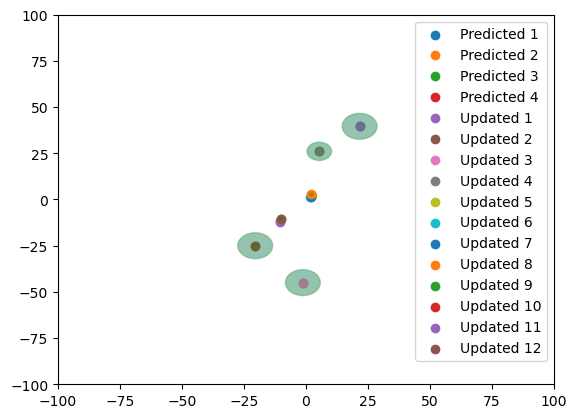

In [37]:
fig, ax = plt.subplots()
for i in range(len(filter.predicted_positions)):
    pos = filter.predicted_positions[i][:2]
    cov = filter.predicted_covariance[i][:2, :2]
    eigvals, eigvecs = np.linalg.eig(cov)
    a = eigvals.argsort()[::-1]
    eigvals = eigvals[a]
    unc = patches.Ellipse(pos, 2 * np.sqrt(eigvals[0]), 2 * np.sqrt(eigvals[1]), angle=0, alpha=0.25)
    ax.scatter(pos[0], pos[1], marker='o', label=f'Predicted {i + 1}')
    ax.add_patch(unc)
    ax.set_xlim(-100, 100)
    ax.set_ylim(-100, 100)
for i in range(len(filter.updated_positions)):
    pos = filter.updated_positions[i][:2]
    cov = filter.updated_covariance[i][:2, :2]
    eigvals, eigvecs = np.linalg.eig(cov)
    a = eigvals.argsort()[::-1]
    eigvals = eigvals[a]
    unc = patches.Ellipse(pos, 2 * np.sqrt(eigvals[0]), 2 * np.sqrt(eigvals[1]), color='green', angle=0, alpha=0.25)
    ax.scatter(pos[0], pos[1], marker='o', label=f'Updated {i + 1}')
    ax.add_patch(unc)
plt.legend()

### Pruning

Over longer and longer periods, the GM-PHD filter will start to hit computational isues as an increasing number of Gaussian components are propagated through each timestep. As demonstrated above, even a single timestep led to a significant increase in components. To mitigate this, the filter heuristically prunes any unnecessary components, either by removing insignificant components or merging similar ones, until only the best components remain.

Three hyperparameters, truncation threshold $T$, merge threshold $U$, and maximum number of remaining components $J_{max}$, determine the output of the pruning step. Prior to execution, the algorithm also initializes a set $I = \{i = 1, ..., J_k | w_k^{(i)} > T\}$ containing the components with weights $w_k > T$, immediately reducing the number of components.

The algorithm then selects the component $j \in I$ with the highest weight and builds a set L, defined as
$$
    L := \{i \in I | (m_k^{(i)} - m_k^{(j)})^T (P_k^{(i)})^{-1} (m_k^{(i)} - m_k^{(j)}) \le U\}.
$$
In other words, $L$ contains each component with a "distance" of up to $U$ from $j$. Here, "distance" between two components is captured by the squared Mahalanobis distance $(m_k^{(i)} - m_k^{(j)})^T (P_k^{(i)})^{-1} (m_k^{(i)} - m_k^{(j)})$.

The components in $L$ are then merged, whereby the weights, means, and covariances are averaged to form a single component:
$$
    \tilde{w}_k = \sum_{i \in L}{w_k^{(i)}} \\
    \tilde{m}_k = \frac{1}{\tilde{w}_k} \sum_{i \in L}{w_k^{(i)} x_k^{(i)}} \\
    \tilde{P}_k = \frac{1}{\tilde{w}_k} \sum_{i \in L}{w_k^{(i)} (P_k^{(i)} + (\tilde{m}_k - m_k^{(i)}) (\tilde{m}_k - m_k^{(i)})^T)}. \\
$$
$L$ is then subtracted from $I$, and the process of selecting the component with the next highest remaining weight and component merging repeats until $I$ is empty.

If the set of components after merging exceeds $J_{max}$, then it is truncated to only include the $J_{max}$ components with the highest weights.

In [38]:
filter.prune_alg()

In [39]:
filter.updated_weights

[0.033333333333333326,
 0.033333333333333326,
 0.033333333333333326,
 0.009999999999999998]

In [40]:
filter.updated_positions        

[array([21.63972319, 39.60019699, -1.09681591, -1.66656635]),
 array([-20.47978276, -25.00823767,   1.00158513,   0.02984763]),
 array([ -1.25757807, -44.96448864,   0.76755223,   1.87042858]),
 array([ 5.36409444, 26.06422874,  0.        ,  0.        ])]

In [41]:
filter.updated_covariance

[array([[50.,  0.,  0.,  0.],
        [ 0., 50.,  0.,  0.],
        [ 0.,  0.,  2.,  0.],
        [ 0.,  0.,  0.,  2.]]),
 array([[50.,  0.,  0.,  0.],
        [ 0., 50.,  0.,  0.],
        [ 0.,  0.,  2.,  0.],
        [ 0.,  0.,  0.,  2.]]),
 array([[50.,  0.,  0.,  0.],
        [ 0., 50.,  0.,  0.],
        [ 0.,  0.,  2.,  0.],
        [ 0.,  0.,  0.,  2.]]),
 array([[25.,  0.,  0.,  0.],
        [ 0., 25.,  0.,  0.],
        [ 0.,  0.,  4.,  0.],
        [ 0.,  0.,  0.,  4.]])]

[[50.  0.]
 [ 0. 50.]]
[[50.  0.]
 [ 0. 50.]]
[[50.  0.]
 [ 0. 50.]]
[[25.  0.]
 [ 0. 25.]]


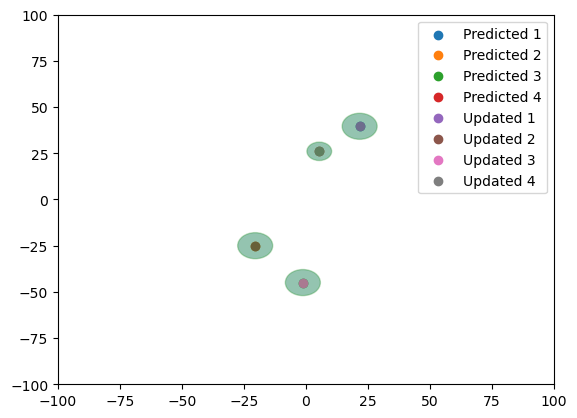

In [42]:
fig, ax = plt.subplots()
for i in range(len(filter.predicted_positions)):
    pos = filter.predicted_positions[i][:2]
    cov = filter.predicted_covariance[i][:2, :2]
    eigvals, eigvecs = np.linalg.eig(cov)
    a = eigvals.argsort()[::-1]
    eigvals = eigvals[a]
    unc = patches.Ellipse(pos, 2 * np.sqrt(eigvals[0]), 2 * np.sqrt(eigvals[1]), angle=0, alpha=0.25)
    ax.scatter(pos[0], pos[1], marker='o', label=f'Predicted {i + 1}')
    ax.add_patch(unc)
    ax.set_xlim(-100, 100)
    ax.set_ylim(-100, 100)
for i in range(len(filter.updated_positions)):
    pos = filter.updated_positions[i][:2]
    cov = filter.updated_covariance[i][:2, :2]
    print(cov)
    eigvals, eigvecs = np.linalg.eig(cov)
    a = eigvals.argsort()[::-1]
    eigvals = eigvals[a]
    unc = patches.Ellipse(pos, 2 * np.sqrt(eigvals[0]), 2 * np.sqrt(eigvals[1]), color='green', angle=0, alpha=0.25)
    ax.scatter(pos[0], pos[1], marker='o', label=f'Updated {i + 1}')
    ax.add_patch(unc)
plt.legend()

The final state estimations selected at time $k$ are from components whose weights $w_k$ are greater than some threshold. For components satisfying this criterium, each weight rounded ($round(w_k^{(i)})$) then corresponds to the number of targets associated with state $m_k^{(i)}$ [i.e., the intensity $v_{k|k-1}(x)$]. In situations where targets are well-separated, rounding weights in this way allows for either 0 or 1 associated target(s) with each component.

In [43]:
filter.return_findings()

[]

###### At $k=0$, predictions are not yet updated, as they only consist of birth predictions

In [44]:
filter.current_measurements = filter.simulated_measurements[1][1]
filter.mtt_phd_whole()

[]

[[50.  0.]
 [ 0. 50.]]
[[50.  0.]
 [ 0. 50.]]
[[50.  0.]
 [ 0. 50.]]
[[25.  0.]
 [ 0. 25.]]
[[25.  0.]
 [ 0. 25.]]


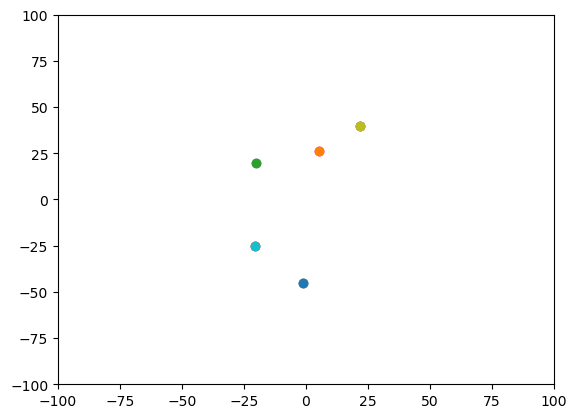

In [45]:
fig, ax = plt.subplots()
for i in range(len(filter.predicted_positions)):
    pos = filter.predicted_positions[i][:2]
    cov = filter.predicted_covariance[i][:2, :2]
    eigvals, eigvecs = np.linalg.eig(cov)
    a = eigvals.argsort()[::-1]
    eigvals = eigvals[a]
    unc = patches.Ellipse(pos, 2 * np.sqrt(eigvals[0]), 2 * np.sqrt(eigvals[1]), angle=0, alpha=0.25)
    ax.scatter(pos[0], pos[1], marker='o', label=f'Predicted {i + 1}')
    # ax.add_patch(unc)
    ax.set_xlim(-100, 100)
    ax.set_ylim(-100, 100)
for i in range(len(filter.updated_positions)):
    pos = filter.updated_positions[i][:2]
    cov = filter.updated_covariance[i][:2, :2]
    print(cov)
    eigvals, eigvecs = np.linalg.eig(cov)
    a = eigvals.argsort()[::-1]
    eigvals = eigvals[a]
    unc = patches.Ellipse(pos, 2 * np.sqrt(eigvals[0]), 2 * np.sqrt(eigvals[1]), color='green', angle=0, alpha=0.25)
    ax.scatter(pos[0], pos[1], marker='o', label=f'Updated {i + 1}')
    # ax.add_patch(unc)

## Full simulation

Provided below is a full simulation of multi-target tracking using the GM-PHD filter.

In [46]:
# assume 3 components
num_components = 3

# assume each component has the same weight
component_weight = 0.5

# the variance of pos and vel
pos_var = 50
vel_var = 2

# each component assumed to start at a random (x, y) ~ U([-100, 100] x [-100, 100])
start_bounds = (-50, 50)

w = [component_weight] * num_components
m = []
for _ in range(num_components):
    m.append(np.array([
            *np.random.uniform(*start_bounds, 2),
            # initial velocity (dx, dy) ~ U(-2, 2) x U(-2, 2)
            *np.random.uniform(-2, 2, 2),
    ]))
m = np.array(m)
P = [np.diag([pos_var, pos_var, vel_var, vel_var]) for _ in range(num_components)]

In [47]:
from gmphd import mtt_phd

# initialize the filter
filter = mtt_phd(
    weights=w,
    position=m,
    p_cov=P,
    num_components=num_components,
    measurement=all_measurements,
    state_transition_matrix=F,
    process_noise_matrix=Q,
    measurement_matrix=H,
    measurement_noise=R,
    num_steps=len(all_measurements),
    detection_probability=0.8,
    clutter_intensity=0.9,
    merging_threshold = 0.7,
    truncation_threshold = 0.01, # make sure squared
    threshold_weight= 0.1
)

In [48]:
# run the filter
history = filter.full_PHD_filter_run()

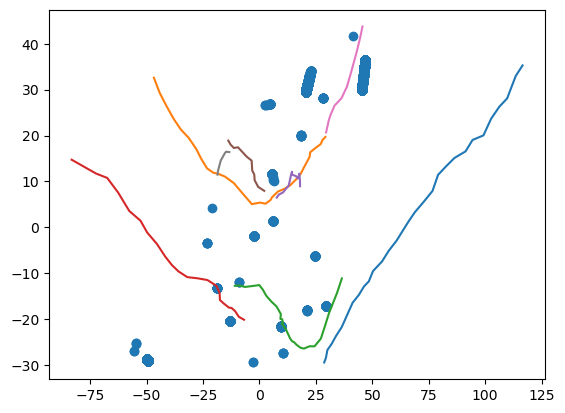

In [49]:
#for i in range(len(history)):
for i in [0]:
    pos = np.array([s[:2] for s in history[i]])
    # print(len(pos))
    plt.scatter(*pos.T, label=f'Step {i + 1}')
for i, state in birth_death_truths.items():
    pos = np.array([s[:2] if s is not None else [np.nan, np.nan] for s in state])
    plt.plot(*pos[:,:2].T, label=f'Component {i + 1}')
# plt.legend()

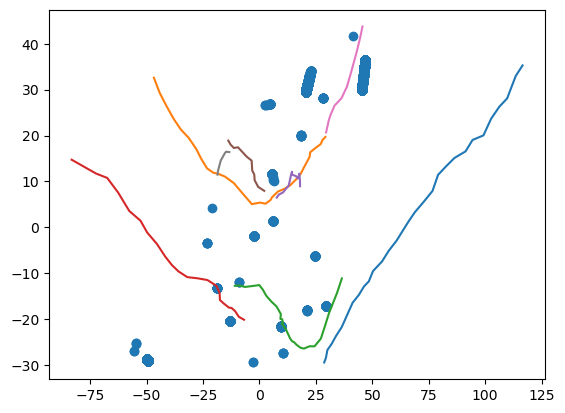

In [53]:
for i in [29]:
    pos = np.array([s[:2] for s in history[i]])
    # print(len(pos))
    plt.scatter(*pos.T, label=f'Step {i + 1}')
for i, state in birth_death_truths.items():
    pos = np.array([s[:2] if s is not None else [np.nan, np.nan] for s in state])
    plt.plot(*pos[:,:2].T, label=f'Component {i + 1}')

12180


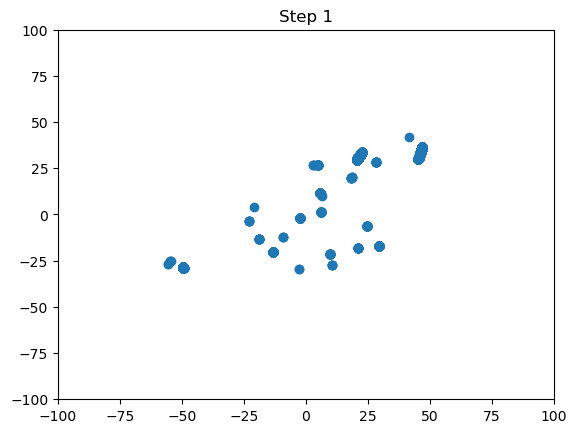

12180


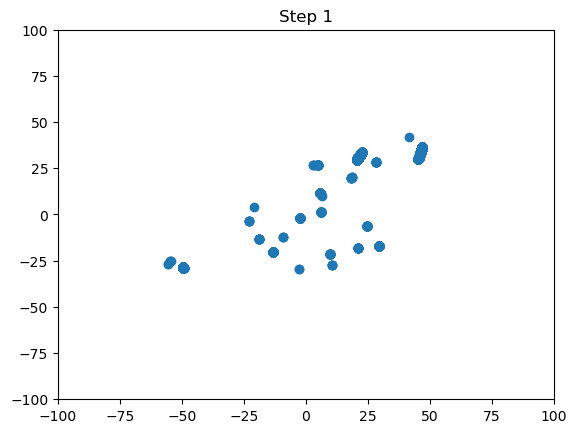

12180


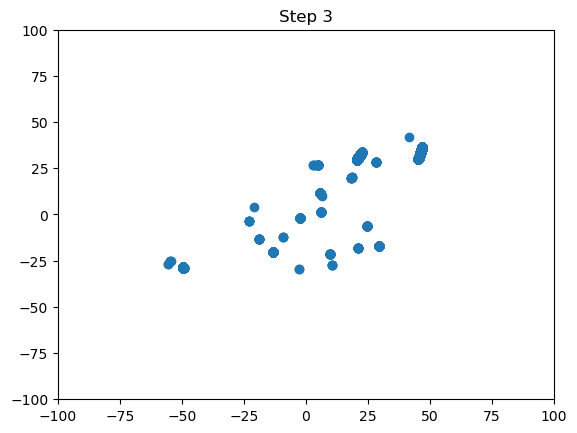

12180


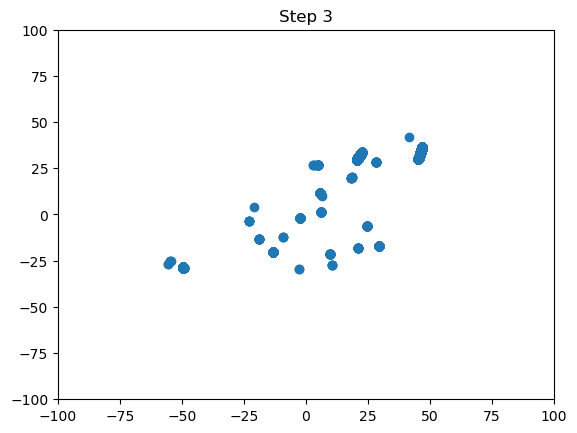

12180


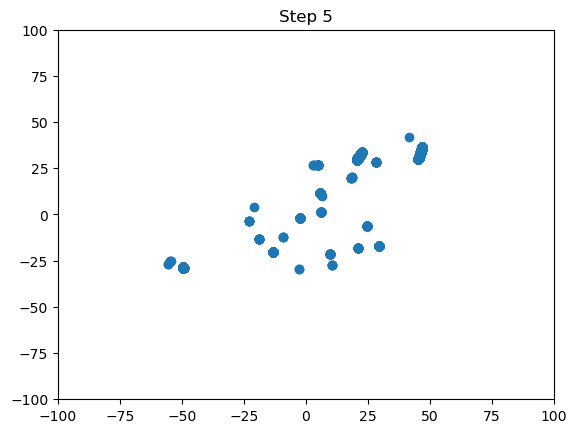

12180


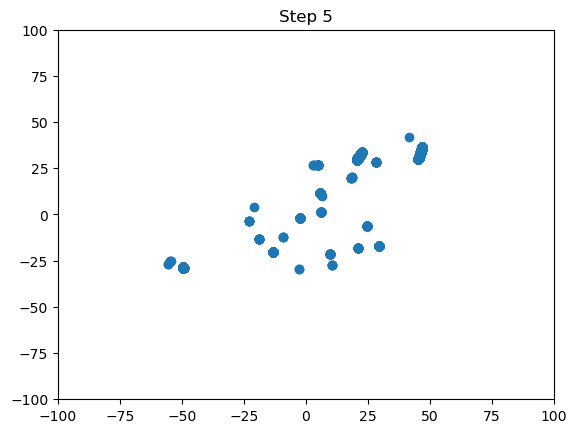

12180


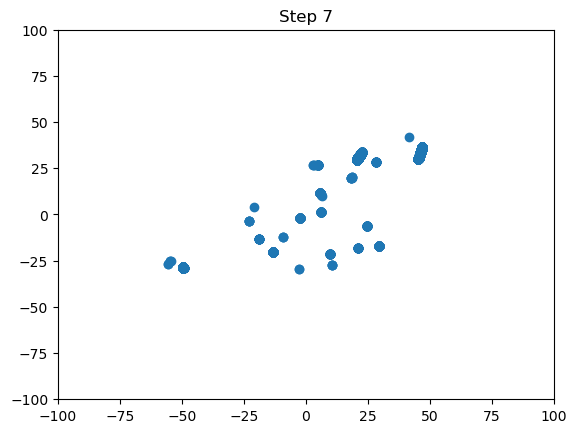

12180


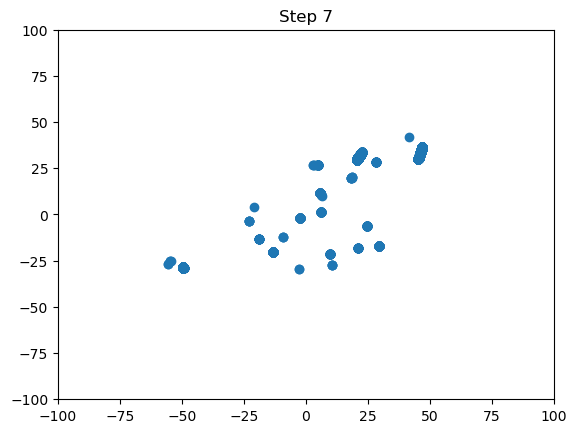

12180


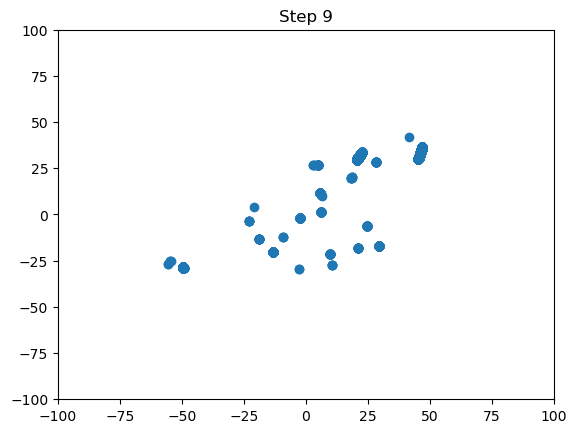

12180


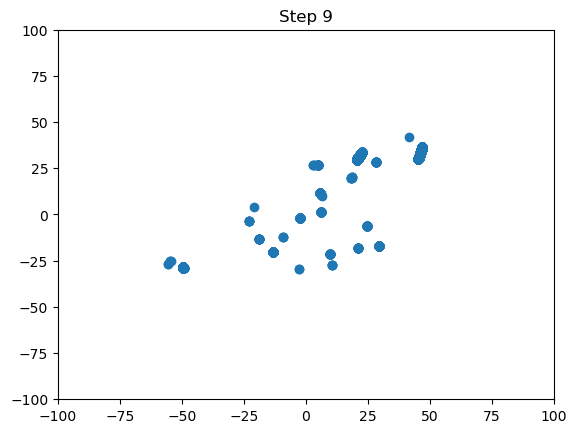

12180


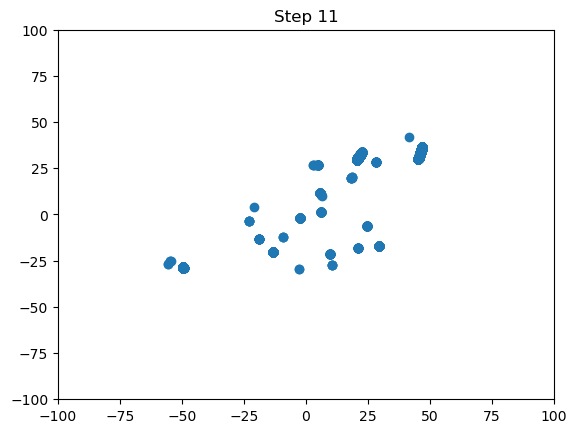

12180


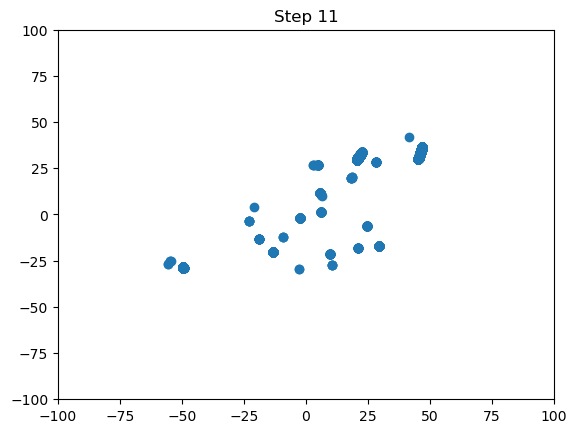

12180


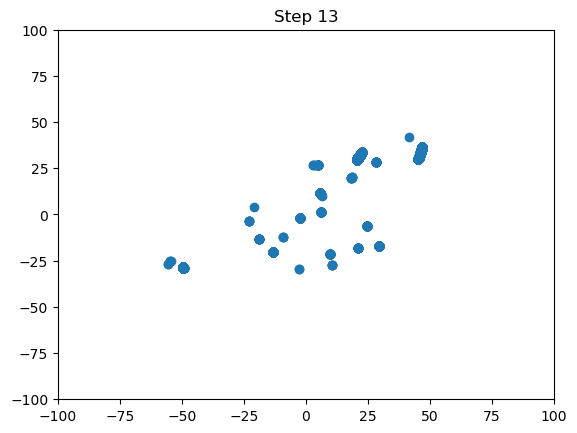

12180


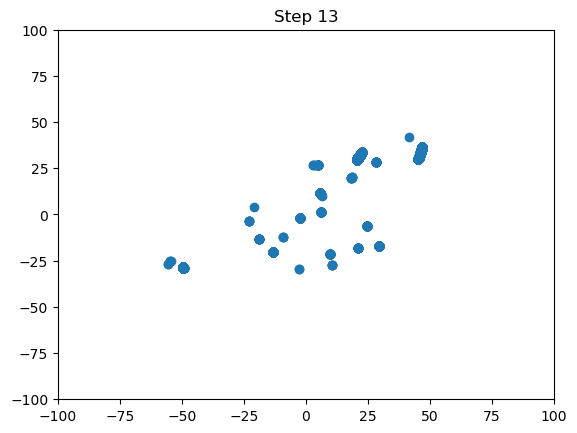

12180


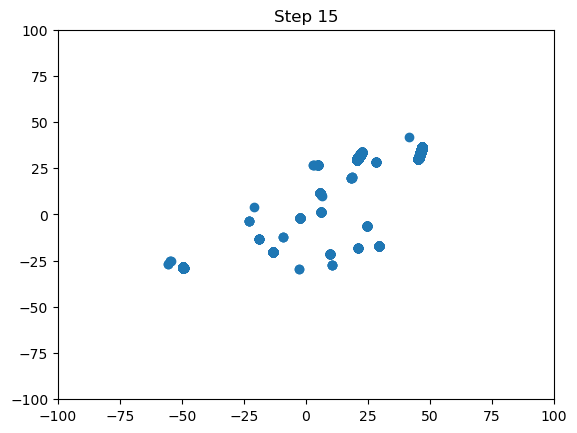

12180


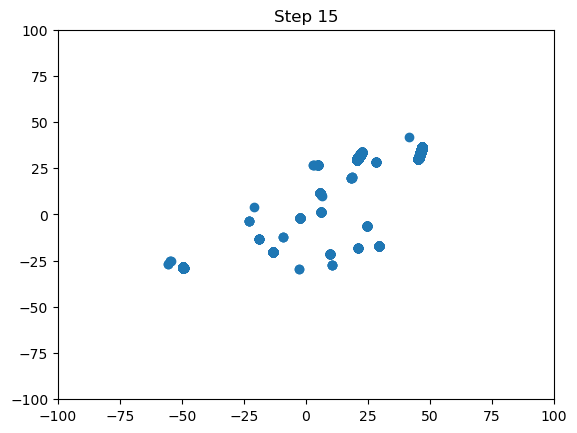

12180


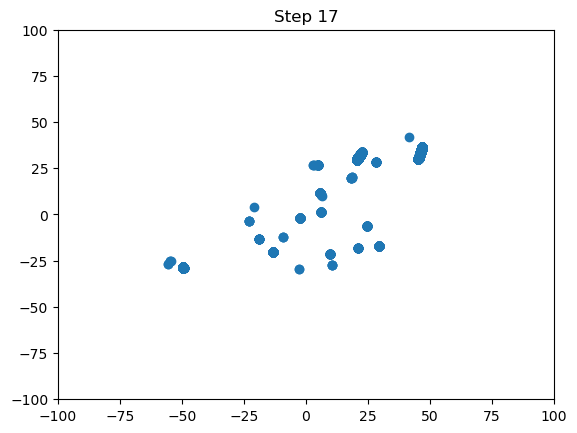

12180


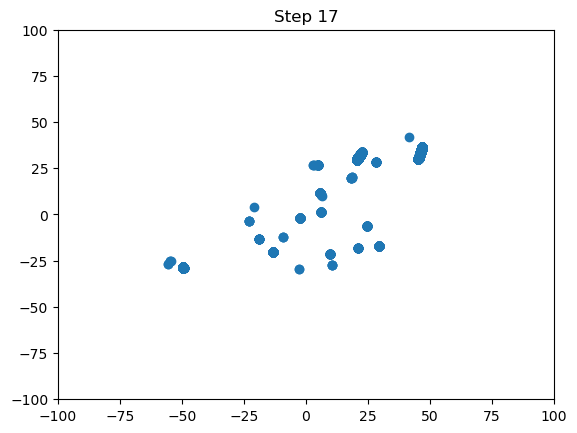

12180


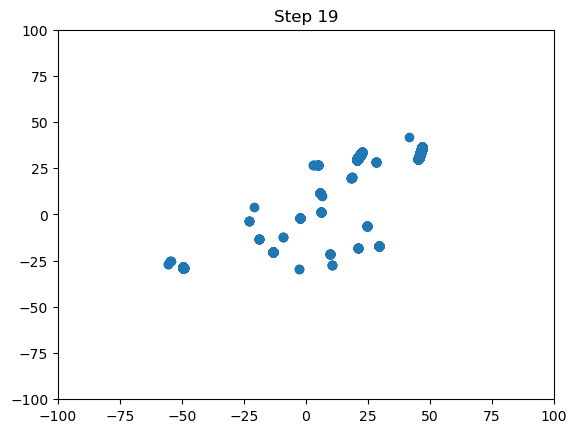

12180


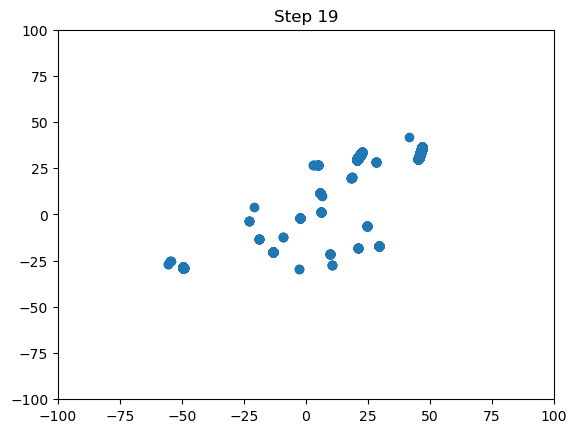

12180


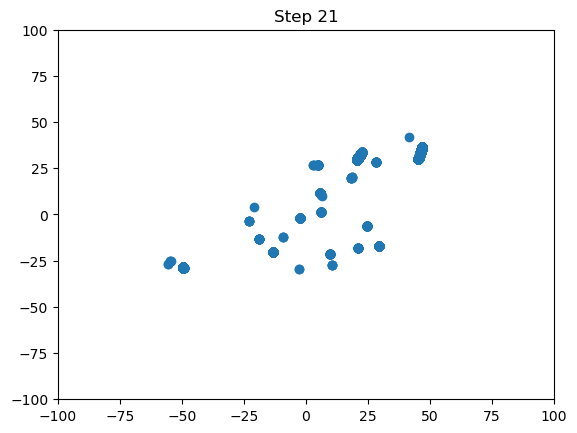

12180


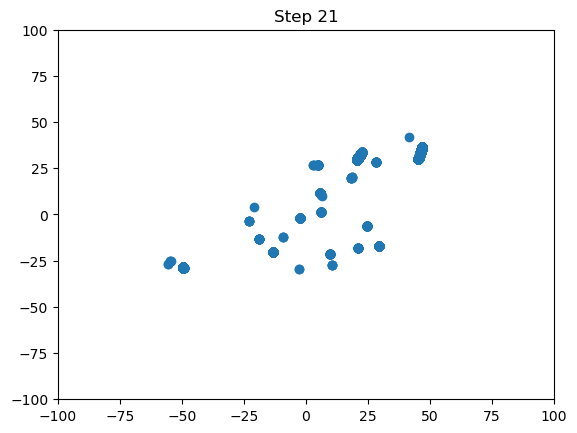

12180


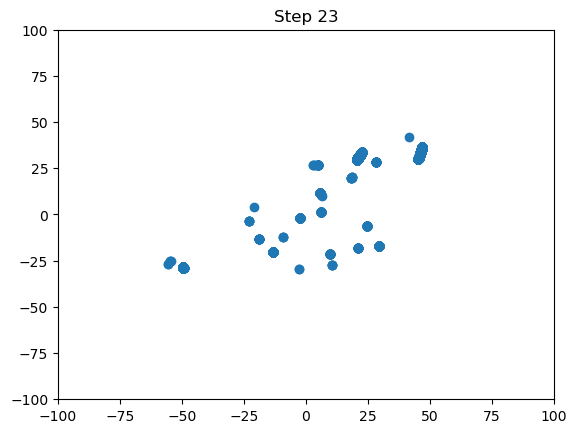

12180


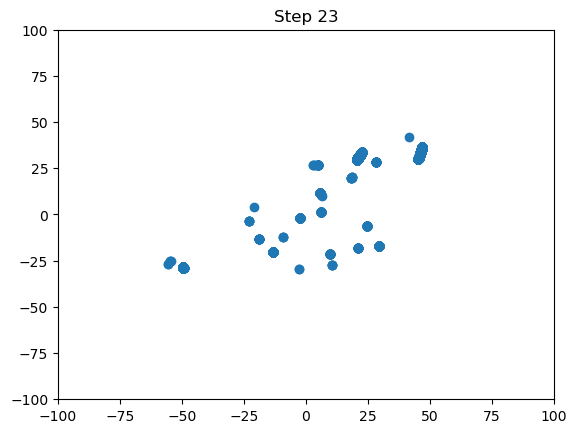

12180


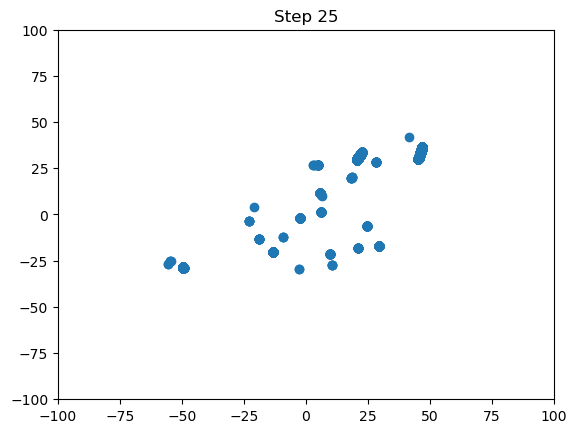

12180


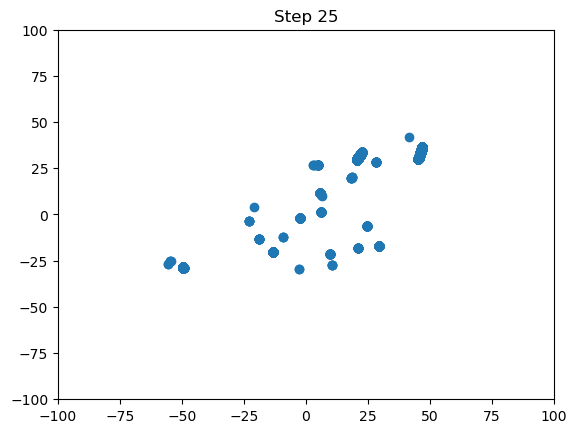

12180


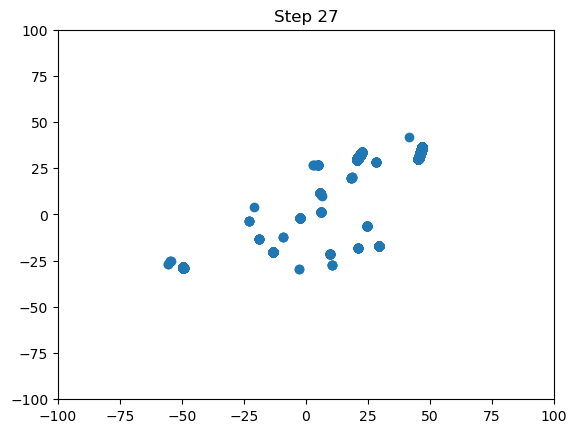

12180


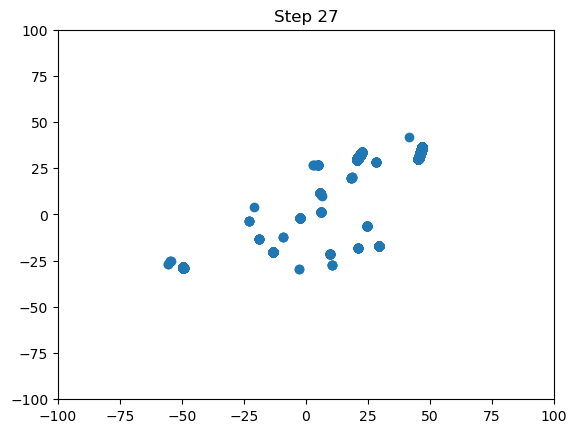

12180


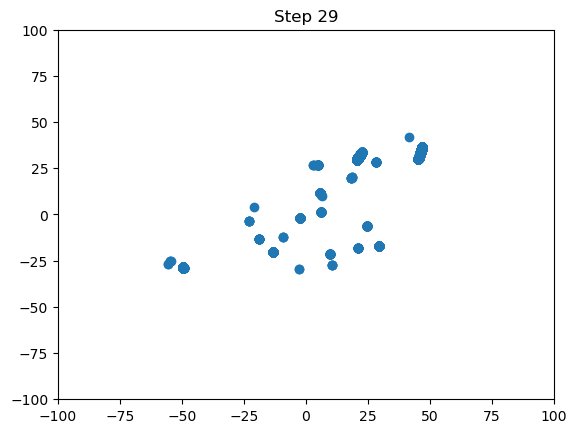

12180


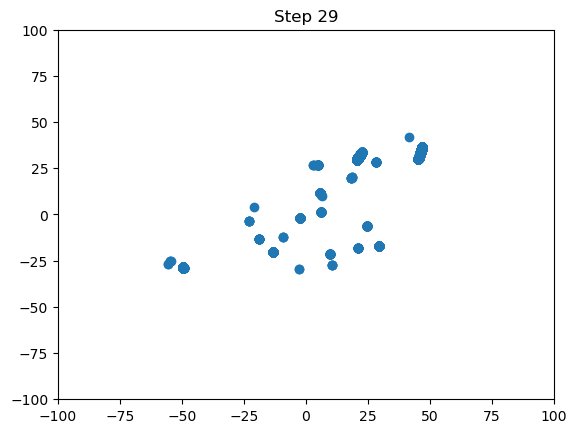

In [50]:
for i in range(len(history)):
    pos = np.array([s[:2] for s in history[i]])
    print(len(pos))
    plt.figure()
    plt.scatter(*pos.T)
    plt.xlim(-100, 100)
    plt.ylim(-100, 100)
    plt.title(f'Step {i |+ 1}')
    plt.show()

In [51]:
len(np.unique(history[0], axis=0))

236

In [52]:
history[2]

[array([45.35692743, 30.13970932,  0.4408581 ,  1.82520945]),
 array([22.58518962, 33.78503954, -0.63086259, -1.31335744]),
 array([-49.3211719 , -29.19219859,  -0.14551443,   0.16088097]),
 array([45.38742738, 30.26598307,  0.4408581 ,  1.82520945]),
 array([22.54154456, 33.69417733, -0.63086259, -1.31335744]),
 array([-49.33123905, -29.18106834,  -0.14551443,   0.16088097]),
 array([45.4195846 , 30.39911813,  0.4408581 ,  1.82520945]),
 array([45.4195846 , 30.39911813,  0.4408581 ,  1.82520945]),
 array([22.49552796, 33.59837796, -0.63086259, -1.31335744]),
 array([22.49552796, 33.59837796, -0.63086259, -1.31335744]),
 array([-49.34185321, -29.1693333 ,  -0.14551443,   0.16088097]),
 array([-49.34185321, -29.1693333 ,  -0.14551443,   0.16088097]),
 array([45.4534278 , 30.53923334,  0.4408581 ,  1.82520945]),
 array([45.4534278 , 30.53923334,  0.4408581 ,  1.82520945]),
 array([45.4534278 , 30.53923334,  0.4408581 ,  1.82520945]),
 array([22.44709875, 33.49755591, -0.63086259, -1.3133